In [1]:
import numpy as np
import sep

In [2]:
import astropy.io.fits as astrofits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize']=[10.,8.]

## Steps 3-6:

#### Read in data:

In [3]:
#filename = astropy.utils.data.get_pkg_data_filename('./image.fits')#astrofits.util.get_testdata_filepath('image.fits')
#print(filename)
astrofits.info('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
file = astrofits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = file[0].data#astrofits.getdata('image.fits')
data = data.byteswap().newbyteorder()

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


#### Show image

0.054868452


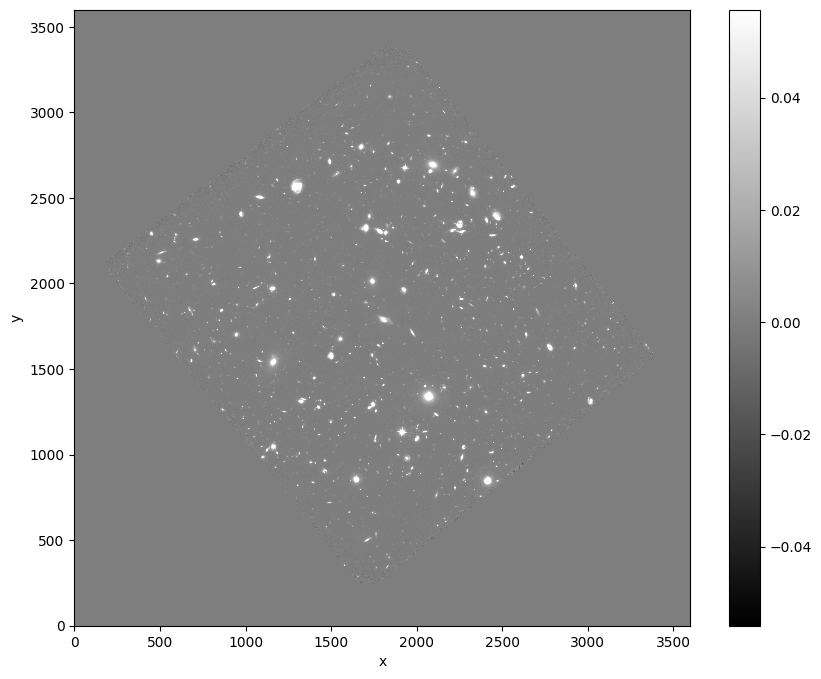

In [4]:
m = np.nanmean(data)
s = np.std(data)
print(s)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("FinalProjectPart2Fig1", bbox_inches = "tight", facecolor="white")

#### Plot background

In [5]:
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


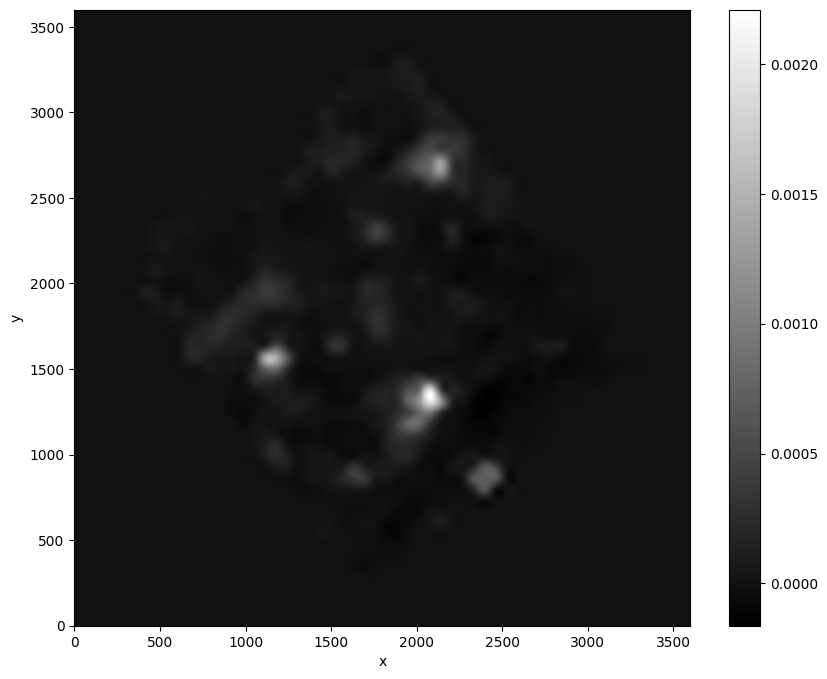

In [6]:
bkg_image=bkg.back()
plt.imshow(bkg_image,interpolation='nearest',cmap='gray',origin='lower')
plt.colorbar();
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("FinalProjectPart2Fig2", bbox_inches = "tight", facecolor="white")

#### Plot background noise

In [7]:
bkg_rms = bkg.rms()

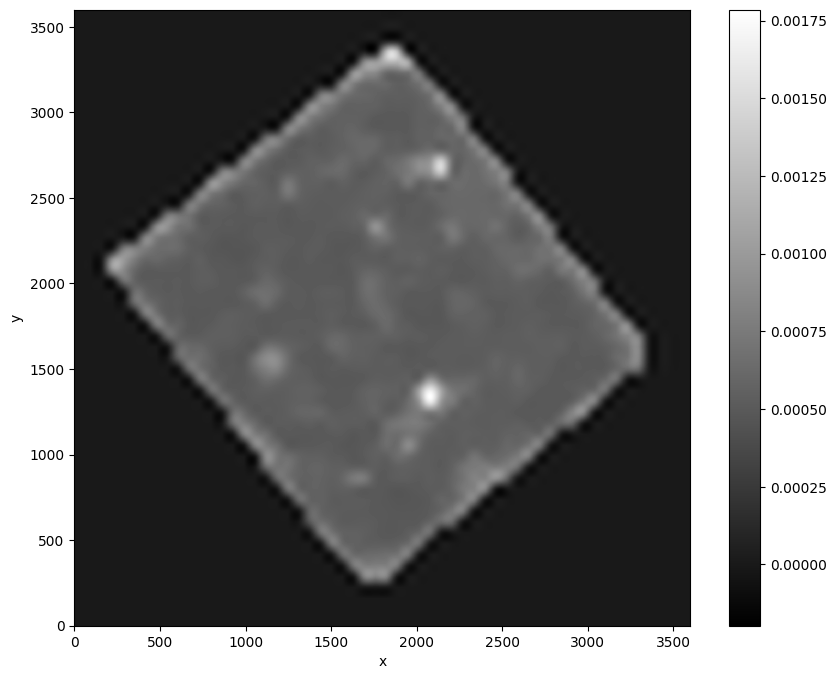

In [8]:
plt.imshow(bkg_rms, interpolation='nearest',cmap='gray', origin='lower')
plt.colorbar();
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("FinalProjectPart2Fig3", bbox_inches = "tight", facecolor="white")

#### Use sep to detect the objects in the image

In [9]:
data_sub = data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

len(objects)

8643

##### len(objects) tells us that 8643 objects were detected in the image

#### Circle objects and plot

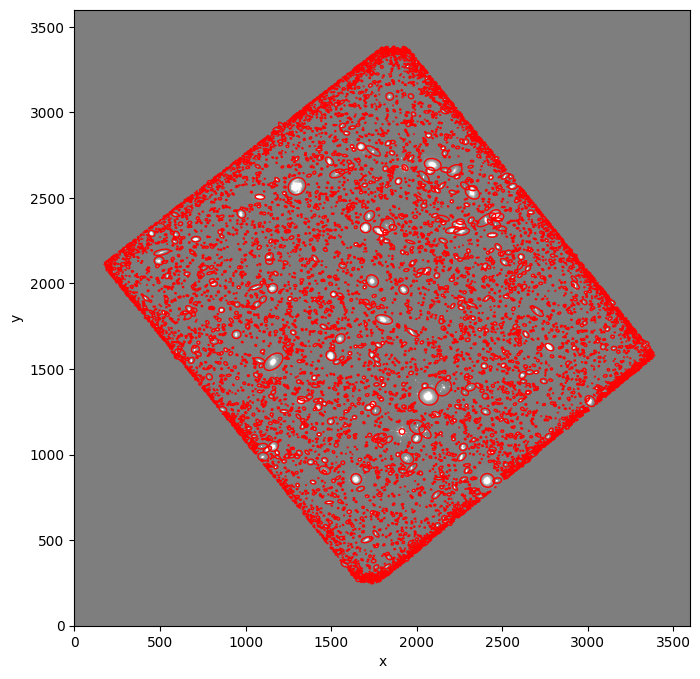

In [10]:
from matplotlib.patches import Ellipse

fig,ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

ax.set_xlabel('x')
ax.set_ylabel('y')
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width=6*objects['a'][i], height=6*objects['b'][i], angle=objects['theta'][i] * 100./np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
plt.savefig("FinalProjectPart2Fig4", bbox_inches = "tight", facecolor="white")

#### List available fields that objects has

In [11]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

#### Measure the light of the objects by performing circular aperture photometry

In [12]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


#### Create a histogram of the fluxes:

808.0


/tmp/ipykernel_227008/969454167.py:3: RuntimeWarning: invalid value encountered in log10
  flux_scaled = -2.5*np.log10(flux)


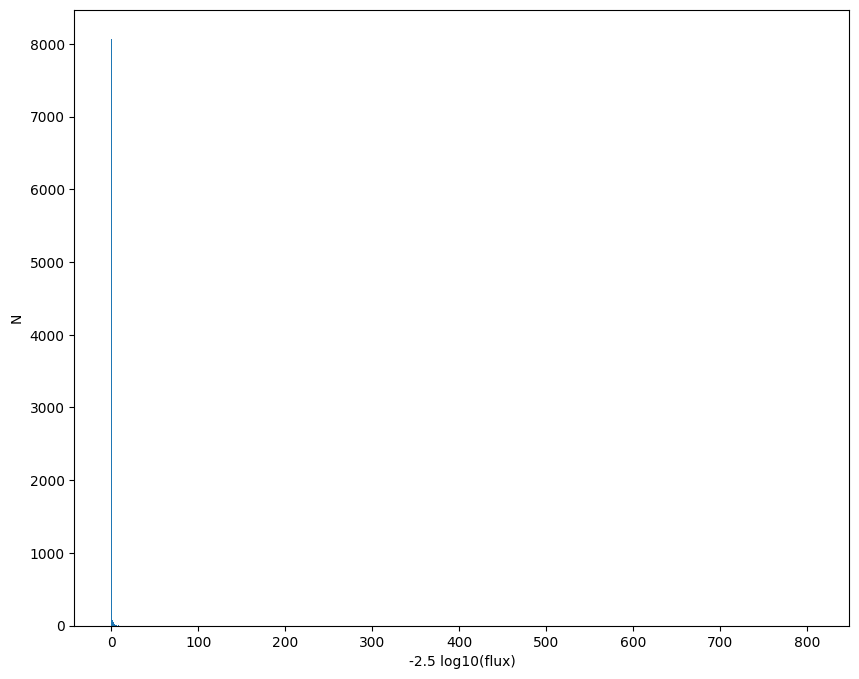

In [13]:
histMin = np.floor(min(flux))
histMax = np.ceil(max(flux))
flux_scaled = -2.5*np.log10(flux)
print(histMax)
bins = np.linspace(histMin, histMax, 1000) #100 bins to start
plt.hist(flux, bins=bins)
#plt.xscale("log")
plt.xlabel("-2.5 log10(flux)")
plt.ylabel("N")
#plt.xlim(2, 50)
#plt.ylim(0, 100)
plt.show()

## Step 7

#### Get mean, median, and standard deviation

In [14]:
mean = np.nanmean(flux)
print(mean)
median = np.nanmedian(flux)
print(median)
std_dev = np.nanstd(flux)
print(std_dev)

0.3617466258281149
0.030954822942148894
9.241925555851745


In [15]:
#histMin = np.floor(min(flux/std_dev))
#histMax = np.ceil(max(flux/std_dev))
#print(histMax)
#bins = np.linspace(histMin, histMax, 1000) #100 bins to start
#plt.hist(flux/std_dev, bins=bins)
#plt.xlabel("flux")
#plt.ylabel("N")
##plt.xlim(2, 50)
##plt.ylim(0, 100)
#plt.show()

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
for i in range(len(objects)):
    if (flux[i] > 50 or flux[i] < -50):
        print("object {:d}: flux = {:f} +/- {:f} {:f}".format(i, flux[i], fluxerr[i], objects[i]['x'], objects[i]['y']))

object 1170: flux = 72.339850 +/- 8.505284 1646.369892
object 1190: flux = 65.907184 +/- 8.118324 2413.517306
object 2059: flux = 807.297284 +/- 28.412978 1914.254909
object 2265: flux = 52.126679 +/- 7.219881 1744.486144
object 2658: flux = 77.974223 +/- 8.830302 2068.859808
object 3431: flux = 55.998238 +/- 7.483198 1162.490346
object 7158: flux = 214.141442 +/- 14.633573 1932.134236
object 7391: flux = 80.557677 +/- 8.975393 1675.423521


#### Largest outlier: object 2059, with flux=807.297284
#### Show on image:

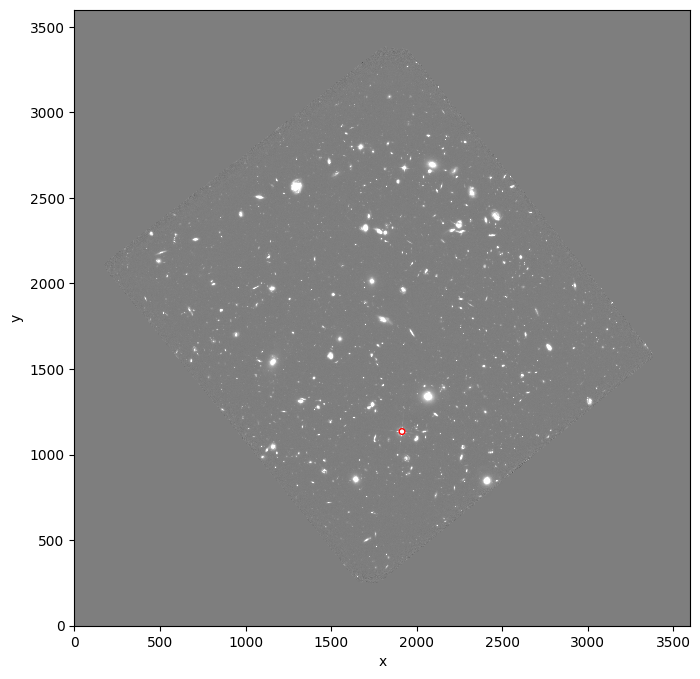

In [17]:
outlier = objects[2059]
#flux, fluxerr, flag = sep.sum_circle(data_sub, outlier['x'], outlier['y'], 3.0, err=bkg.globalrms, gain=1.0)
from matplotlib.patches import Ellipse

fig,ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

e = Ellipse(xy=(objects['x'][2059], objects['y'][2059]), width=6*objects['a'][2059], height=6*objects['b'][2059], angle=objects['theta'][2059] * 100./np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)
ax.set_xlabel('x')
ax.set_ylabel('y')
    
plt.savefig("FinalProjectPart2Fig5", bbox_inches = "tight", facecolor="white")

The outlier's flux is 807.297284, while the mean of the objects is 0.3617466258281149. To find how many standard deviations away the outlier is from the mean:

In [18]:
outlierStd = flux[2059]
print(outlierStd)
#subtract the mean from the outlier
outlierStd = outlierStd - mean
print(outlierStd)
#divide the outlier by the std dev:
outlierStd = outlierStd / std_dev
print(outlierStd)


807.2972835731507
806.9355369473226
87.31249046216263


So the outlier is about 87.31 standard deviations away from the mean.

## Step 8
#### Open the two other files and read in their data the same way as the first image file

In [19]:
astrofits.info('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')
file160 = astrofits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')
data160 = file160[0].data#astrofits.getdata('image.fits')
data160 = data160.byteswap().newbyteorder()
astrofits.info('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
file125 = astrofits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
data125 = file160[0].data#astrofits.getdata('image.fits')
data125 = data160.byteswap().newbyteorder()
x = 0
test = np.arange(3600)
#print(data160[0, 1800])
#for i in data160:
#    if i[1000] > 0:
#        print(i[1000])
#    x+=1
print(x)

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     358   (3600, 3600)   float32   
Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     358   (3600, 3600)   float32   
0


#### Normalize the data

In [20]:
def rescale_data(data, dmin=0.01, dmax=10.0):
    dataclipped = np.clip(data, dmin, dmax)
    return (np.log10(dataclipped)-np.log10(dmin))/(np.log10(dmax)-np.log10(dmin))

In [21]:
data160Log = rescale_data(data160)
data125Log = rescale_data(data125)
dataLog = rescale_data(data)

In [22]:
rgb = np.stack([data160Log, data125Log, dataLog], axis=-1)

#### Create an empty array to be the image and then set each of the 3 axes representing the RGB channels to be one of the imported files, so that each channel (red, green, blue) is taken from a different file. Then display and save the resulting image.

[W 2024-12-10 11:35:49,417.417 matplotlib.image] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


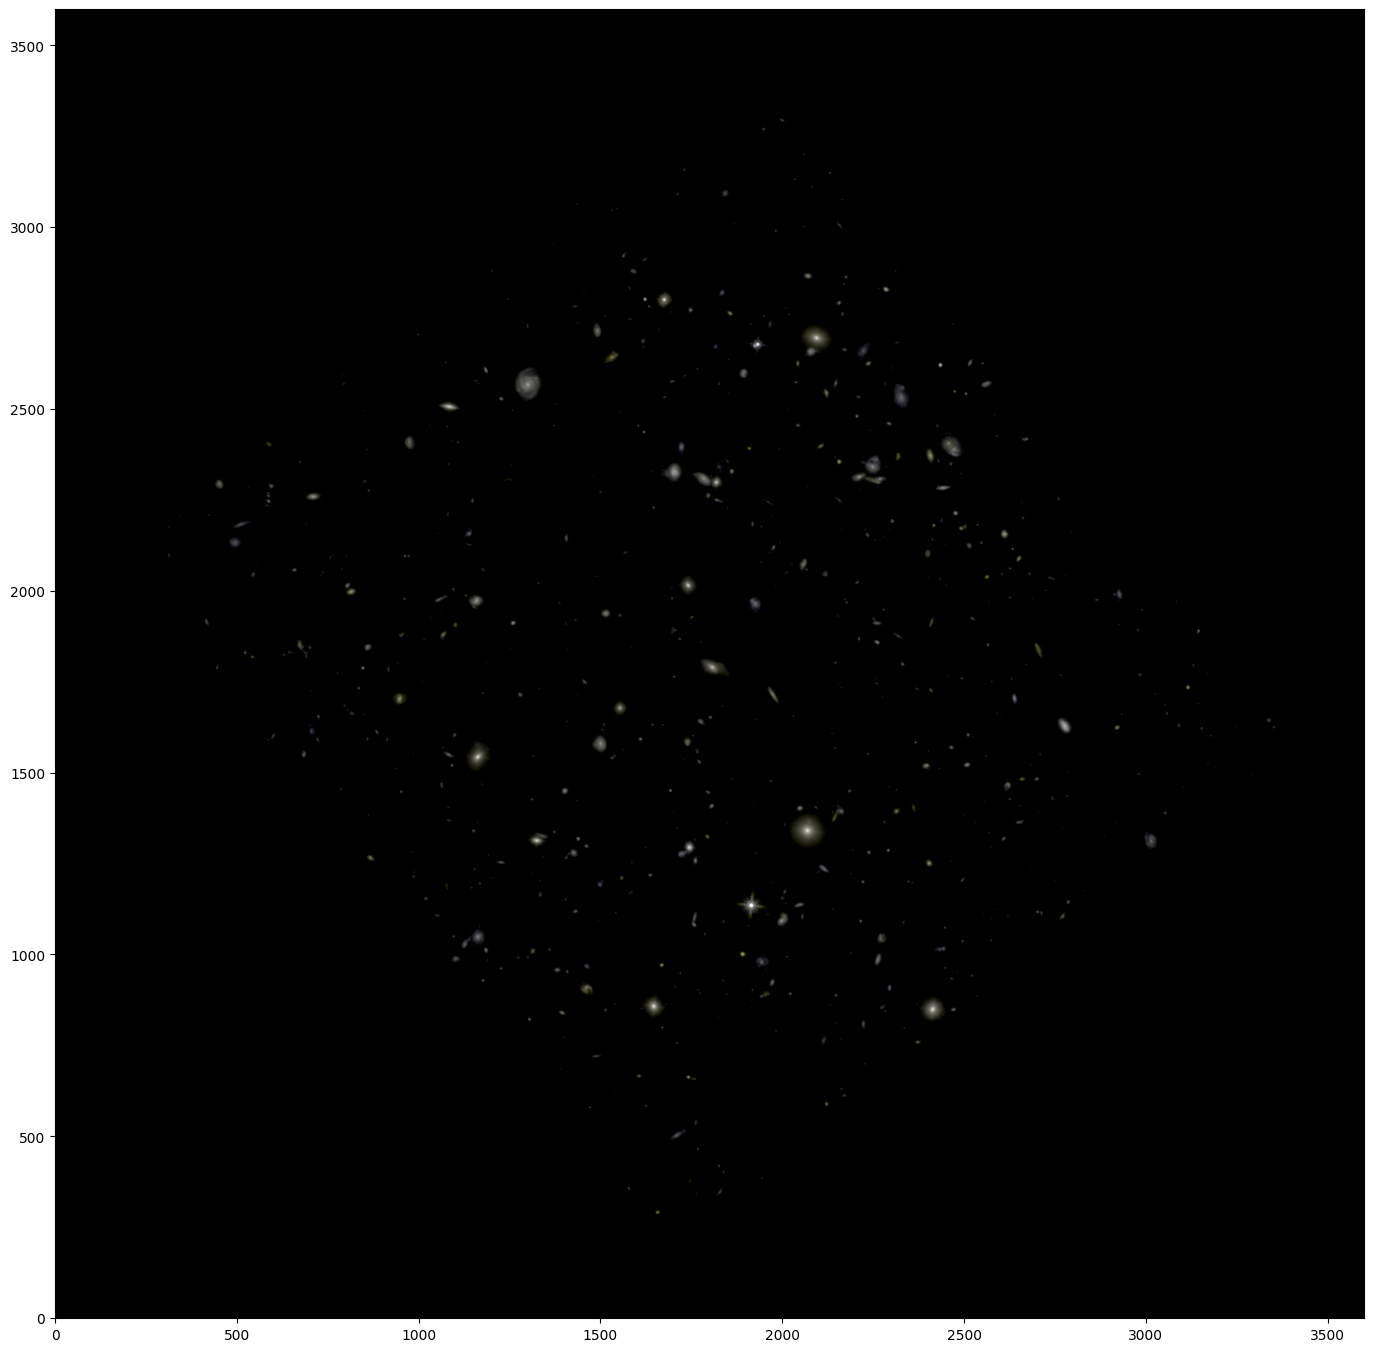

In [23]:
#rgb_image = np.zeros((3600,3600,3))
#rgb_image[:,:,0] = r
#rgb_image[:,:,1] = g
#rgb_image[:,:,2] = b
figure = plt.figure(figsize=(17,17))
plt.imshow(rgb,origin='lower')
plt.savefig('FinalProjectRGBFig.png', bbox_inches='tight', facecolor='white')